## [Modeling complex time series](https://github.com/marcopeix/TimeSeriesForecastingInPython/blob/master/CH06/CH06.ipynb)

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [26]:
np.random.seed(42)

ar1 = np.array([1, -0.33])
ma1 = np.array([1, 0.9])

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)



In [27]:
ADF_result = adfuller(ARMA_1_1)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -6.429878682042683
p-value: 1.7078466680097572e-08


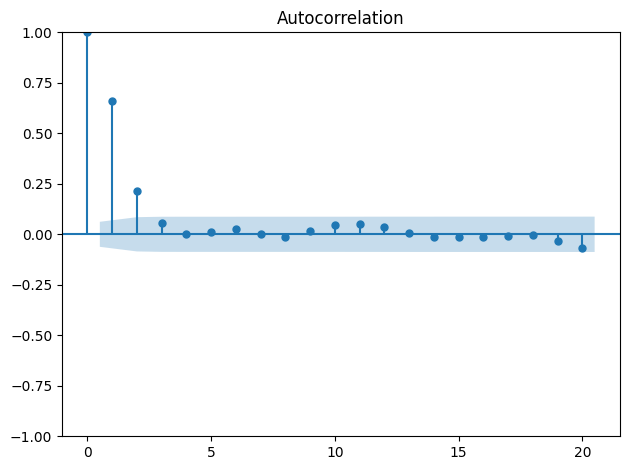

In [28]:
plot_acf(ARMA_1_1, lags=20);

plt.tight_layout()

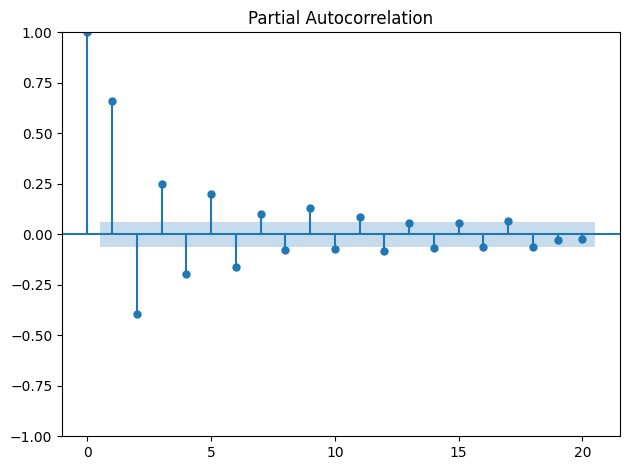

In [29]:
plot_pacf(ARMA_1_1, lags=20);

plt.tight_layout()

In [30]:
# Selecting the best model
ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))
print(order_list)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]


In [31]:
from typing import Union

def optimize_ARMA(endog: Union[pd.Series, list], order_list: list) -> pd.DataFrame:
    results = []

    for order in order_list:
        try:
            model = SARIMAX(endog, order=(order[0], 0, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    return result_df

In [32]:
result_df = optimize_ARMA(ARMA_1_1, order_list)
result_df

C:\envs\vertr\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\envs\vertr\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\envs\vertr\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,"(p,q)",AIC
0,"(1, 1)",2801.407785
1,"(2, 1)",2802.906070
2,"(1, 2)",2802.967762
3,"(0, 3)",2803.666793
4,"(1, 3)",2804.524027
5,"(3, 1)",2804.588567
6,"(2, 2)",2804.822282
7,"(3, 3)",2806.020523
8,"(2, 3)",2806.175380
9,"(3, 2)",2806.894930


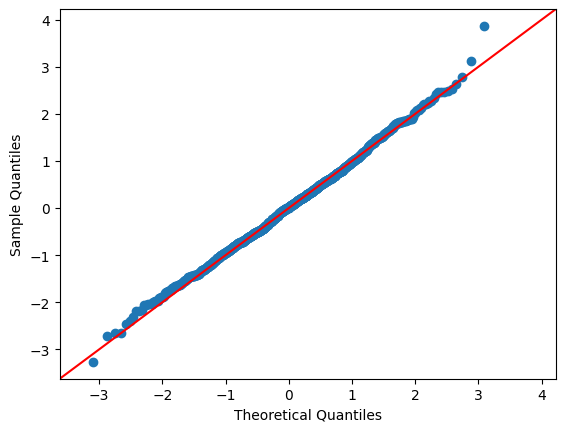

In [33]:
# Performing residuals analysis

from statsmodels.graphics.gofplots import qqplot

model = SARIMAX(ARMA_1_1, order=(1,0,1), simple_differencing=False)
model_fit = model.fit(disp=False)
residuals = model_fit.resid

qqplot(residuals, line='45');

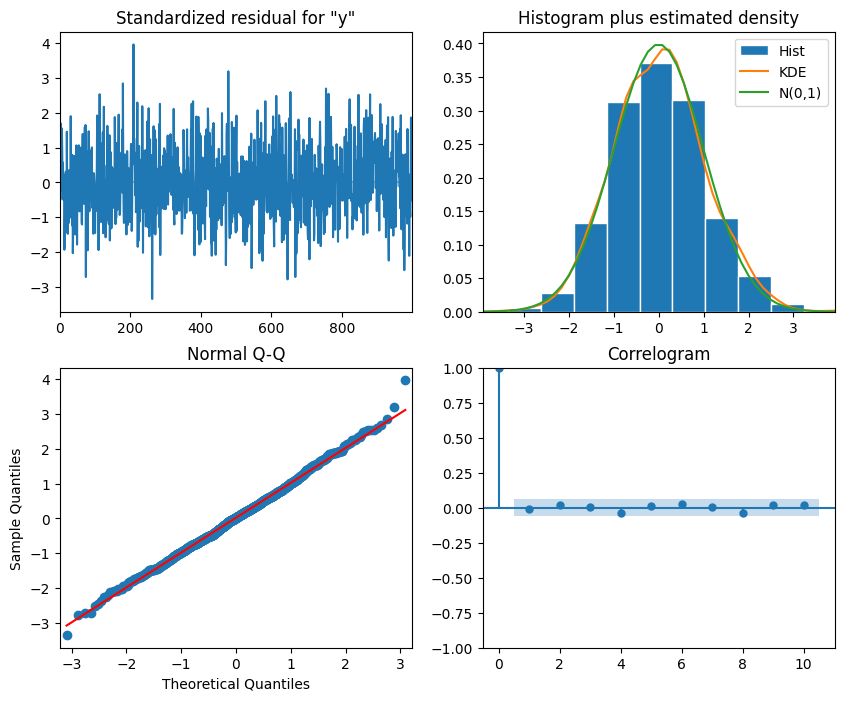

In [34]:
model_fit.plot_diagnostics(figsize=(10, 8));

In [35]:
df = pd.read_csv('../data/bandwidth.csv')

df.head()

,hourly_bandwidth
0,1000.496714
1,1000.969408
2,1002.046019
3,1004.702118
4,1007.447816


In [36]:
ADF_result = adfuller(df['hourly_bandwidth'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')


ADF Statistic: -0.8714653199452242
p-value: 0.7972240255014709


In [37]:
bandwidth_diff = np.diff(df.hourly_bandwidth, n=1)
ADF_result = adfuller(bandwidth_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -20.694853863789024
p-value: 0.0


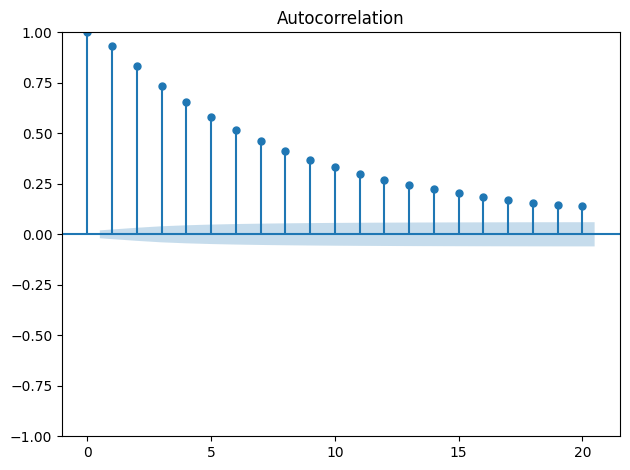

In [38]:
plot_acf(bandwidth_diff, lags=20);

plt.tight_layout()

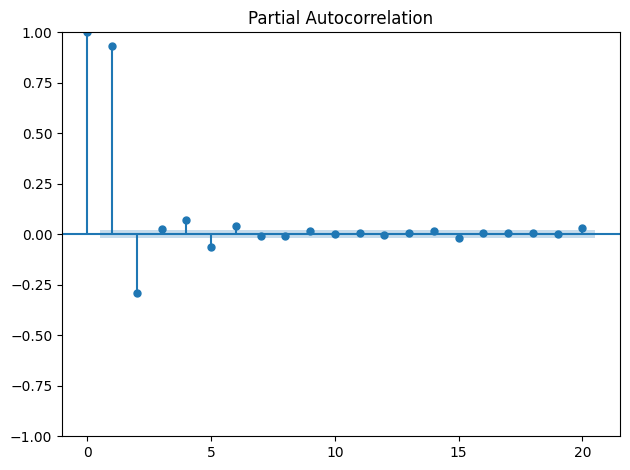

In [39]:
plot_pacf(bandwidth_diff, lags=20);

plt.tight_layout()

In [40]:
df_diff = pd.DataFrame({'bandwidth_diff': bandwidth_diff})

train = df_diff[:-168]
test = df_diff[-168:]

print(len(train))
print(len(test))

9831
168


In [41]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)

order_list = list(product(ps, qs))

In [42]:
result_df = optimize_ARMA(train['bandwidth_diff'], order_list)
result_df

C:\envs\vertr\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\envs\vertr\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\envs\vertr\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,"(p,q)",AIC
0,"(3, 2)",27991.063879
1,"(2, 3)",27991.287509
2,"(2, 2)",27991.603598
3,"(3, 3)",27993.416924
4,"(1, 3)",28003.349550
5,"(1, 2)",28051.351401
6,"(3, 1)",28071.155496
7,"(3, 0)",28095.618186
8,"(2, 1)",28097.250766
9,"(2, 0)",28098.407664


In [59]:
model = SARIMAX(train['bandwidth_diff'], order=(3,0,2), simple_differencing=False)
model_fit = model.fit(disp=False)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:         bandwidth_diff   No. Observations:                 9831
Model:               SARIMAX(3, 0, 2)   Log Likelihood              -13989.532
Date:                Sun, 26 Oct 2025   AIC                          27991.064
Time:                        18:02:35   BIC                          28034.224
Sample:                             0   HQIC                         28005.686
                               - 9831                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3532      0.053      6.668      0.000       0.249       0.457
ar.L2          0.4150      0.066      6.250      0.000       0.285       0.545
ar.L3          0.0546      0.036      1.530      0.1

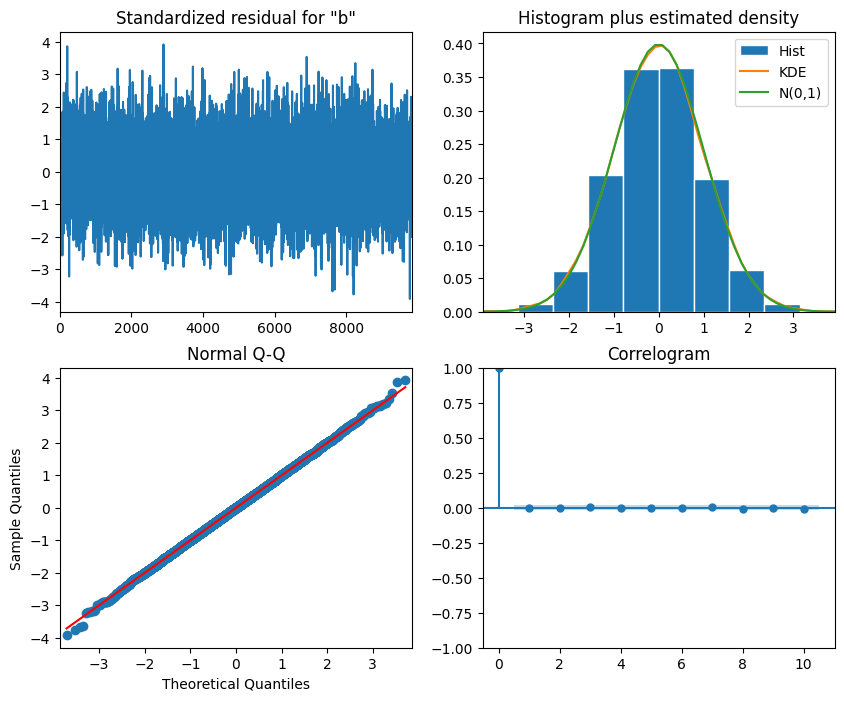

In [60]:
model_fit.plot_diagnostics(figsize=(10, 8));


In [61]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = model_fit.resid

stat = acorr_ljungbox(residuals, np.arange(1, 11, 1), return_df=True)

stat

,lb_stat,lb_pvalue
1,0.000729,0.978461
2,0.015352,0.992353
3,0.044845,0.997508
4,0.081030,0.999201
5,0.311132,0.997428
6,0.359370,0.999154
7,0.448530,0.999614
8,1.350781,0.994917
9,1.371062,0.997995
10,1.871109,0.997236


In [62]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon
    end_idx = train_len

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'ARMA':
        pred_ARMA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)

        return pred_ARMA

In [63]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

test.head()

C:\Users\A\AppData\Local\Temp\ipykernel_623840\3552074462.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_mean'] = pred_mean
C:\Users\A\AppData\Local\Temp\ipykernel_623840\3552074462.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'pred_last_value'] = pred_last_value
C:\Users\A\AppData\Local\Temp\ipykernel_623840\3552074462.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

,bandwidth_diff,pred_mean,pred_last_value,pred_ARMA
9831,-5.943995,-0.028214,-5.791207,-5.460661
9832,-5.865194,-0.028214,-5.791207,-4.890626
9833,-3.197066,-0.029410,-5.865194,-5.335905
9834,-1.090197,-0.029410,-5.865194,-4.751731
9835,0.665291,-0.029840,-1.090197,-0.375596


In [64]:
mse_mean = mean_squared_error(test['bandwidth_diff'], test['pred_mean'])
mse_last = mean_squared_error(test['bandwidth_diff'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['bandwidth_diff'], test['pred_ARMA'])

print(mse_mean, mse_last, mse_ARMA)

6.306526957989325 2.2297582947733656 1.7690462115095413


In [65]:
df['pred_bandwidth'] = pd.Series()
df['pred_bandwidth'][9832:] = df['hourly_bandwidth'].iloc[9832] + test['pred_ARMA'].cumsum()

C:\Users\A\AppData\Local\Temp\ipykernel_623840\1042864100.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['pred_bandwidth'][9832:] = df['hourly_bandwidth'].iloc[9832] + test['pred_ARMA'].cumsum()
C:\Users\A\AppData\Local\Temp\ipykerne

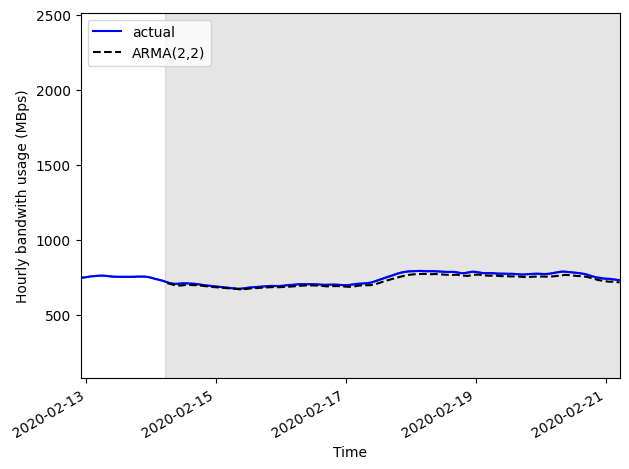

In [66]:
fig, ax = plt.subplots()

ax.plot(df['hourly_bandwidth'])
ax.plot(df['hourly_bandwidth'], 'b-', label='actual')
ax.plot(df['pred_bandwidth'], 'k--', label='ARMA(2,2)')

ax.legend(loc=2)

ax.set_xlabel('Time')
ax.set_ylabel('Hourly bandwith usage (MBps)')

ax.axvspan(9831, 10000, color='#808080', alpha=0.2)

ax.set_xlim(9800, 9999)

plt.xticks(
    [9802, 9850, 9898, 9946, 9994],
    ['2020-02-13', '2020-02-15', '2020-02-17', '2020-02-19', '2020-02-21'])

fig.autofmt_xdate()
plt.tight_layout()


In [67]:
mae_ARMA_undiff = mean_absolute_error(df['hourly_bandwidth'][9832:], df['pred_bandwidth'][9832:])

print(mae_ARMA_undiff)

14.000362772490876
